In [269]:
import pandas as pd
from sklearn import svm
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Solar Flare Classifier

The goal of this analysis is to write a Support Vector Machine which will classify solar flare type. Our output class will roughly be the "flare_class" column of the DataFrame below. For simplicity, I have boiled the flare class to simply be a letter. "B" for all B class flares, "C", for all C class flares, "A" for all A class flares, "M" for all M class flares, and "X" for all X class flares. In the file `xray_data_wrangling.ipynb`, we have code which one-hot-encodes "flare_class" column. These are the columns "B", "C", "M", "X", and "A". The input features will be the "xrsb_flux", the "background_flux" and the "integrated_flux", all of which will be standardized.

Note: To eliminate noise, we will consider only the PEAK x-ray flux data of each solar event. This means that we will consider only the rows of the DataFrame which have a "status" of "EVENT_PEAK". 

In [270]:
xrayData = pd.read_csv("data/xrsSummaryOneHotEncoded.csv")
xrayData.dropna(inplace=True)
xrayData["flux_standardized"] = (xrayData['xrsb_flux'] - xrayData['xrsb_flux'].mean()) / xrayData['xrsb_flux'].std()
xrayData["background_standardized"] = (xrayData['background_flux'] - xrayData['background_flux'].mean()) / xrayData['background_flux'].std()
xrayData["integrated_standardized"] = (xrayData['integrated_flux'] - xrayData['integrated_flux'].mean()) / xrayData['integrated_flux'].std()
display(xrayData.head())
# Consider only the peak of each solar event
xrayData = xrayData[xrayData.status == "EVENT_PEAK"]
xrayData.head()

,time,xrsb_flux,status,background_flux,flare_class,integrated_flux,flare_counter,B,C,M,X,A,flare_type,flux_standardized,background_standardized,integrated_standardized
0,2010-04-08 02:32:00,4.636548e-08,EVENT_START,4.900671e-08,0,0.000041,1.0,0,0,0,0,0,0,-0.170930,-0.336641,-0.128009
1,2010-04-08 03:23:00,5.484352e-07,EVENT_PEAK,4.900671e-08,B5.4,0.001032,1.0,1,0,0,0,0,B,-0.135394,-0.336641,-0.070548
2,2010-04-08 04:05:00,3.448127e-07,EVENT_START,3.448127e-07,0,0.000169,2.0,0,0,0,0,0,0,-0.149806,-0.237807,-0.120552
3,2010-04-08 04:14:00,3.702122e-07,EVENT_PEAK,3.448127e-07,B3.7,0.000277,2.0,1,0,0,0,0,B,-0.148008,-0.237807,-0.114311
4,2010-04-08 04:18:00,3.524697e-07,EVENT_END,3.448127e-07,0,0.000298,2.0,0,0,0,0,0,0,-0.149264,-0.237807,-0.113085


,time,xrsb_flux,status,background_flux,flare_class,integrated_flux,flare_counter,B,C,M,X,A,flare_type,flux_standardized,background_standardized,integrated_standardized
1,2010-04-08 03:23:00,5.484352e-07,EVENT_PEAK,4.900671e-08,B5.4,0.001032,1.0,1,0,0,0,0,B,-0.135394,-0.336641,-0.070548
3,2010-04-08 04:14:00,3.702122e-07,EVENT_PEAK,3.448127e-07,B3.7,0.000277,2.0,1,0,0,0,0,B,-0.148008,-0.237807,-0.114311
7,2010-04-08 17:00:00,1.083563e-07,EVENT_PEAK,4.860522e-08,B1.0,0.000052,3.0,1,0,0,0,0,B,-0.166543,-0.336775,-0.127351
11,2010-04-09 04:55:00,5.549241e-07,EVENT_PEAK,3.353664e-08,B5.5,0.000353,4.0,1,0,0,0,0,B,-0.134935,-0.341810,-0.109909
15,2010-04-09 20:21:00,1.260278e-07,EVENT_PEAK,7.706320e-08,B1.2,0.000050,5.0,1,0,0,0,0,B,-0.165292,-0.327267,-0.127459


## Define Input Features and Output Classes

First, drop all "A" class flares. There are only **two**, so if both are includinig in training or if both are included in testing an error will be thrown

In [271]:
xrayData = xrayData[xrayData['flare_type'] != "A"]

split = 0.7
trainCount = int(split * len(xrayData))
trainIndices = np.random.choice(xrayData.index,trainCount,replace=False)
train = xrayData[xrayData.index.isin(trainIndices)]
test = xrayData[xrayData.index.isin(trainIndices) == False]
# train = xrayData[0:cutoff]
# test = xrayData[cutoff:-1]
features = ['flux_standardized', 'background_standardized', 'integrated_standardized']
# features = ['xrsb_flux', 'background_flux', 'integrated_flux']
X = xrayData[features]
trainX = train[features]
testX = test[features]

# classNames = ["A","B", "C", "M", "X"]
classNames = ["B", "C", "M", "X"]
classes = ['flare_type']
y = xrayData[classes]
trainY = train[classes]
testY = test[classes]


## Plot Data with Classes

In [272]:
size = len(xrayData)
subset = xrayData[0:size]
step = [i for i in range(size)]

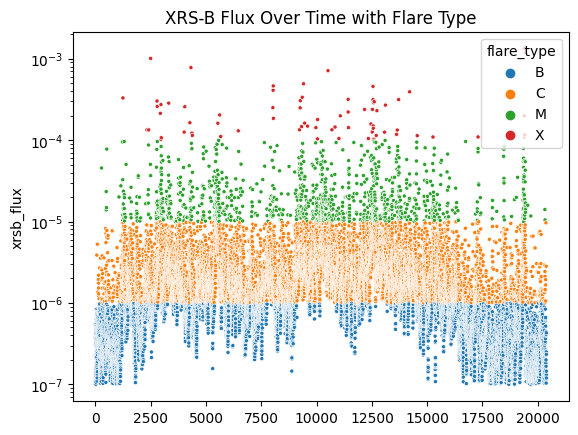

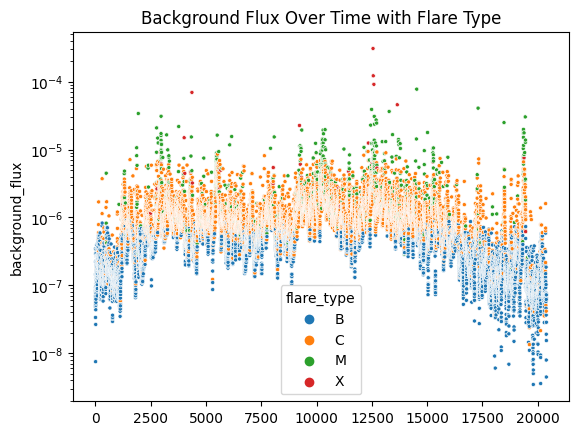

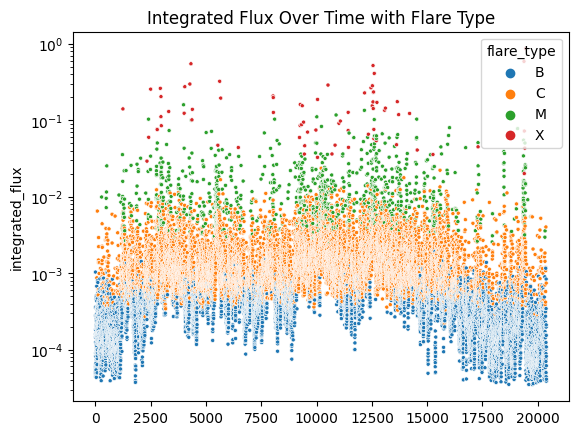

In [273]:
sns.scatterplot(data=subset, x=step, y='xrsb_flux', hue='flare_type', marker=".")
plt.yscale("log")
plt.title("XRS-B Flux Over Time with Flare Type")
plt.show()
sns.scatterplot(data=subset, x=step, y='background_flux', hue='flare_type', marker=".")
plt.yscale("log")
plt.title("Background Flux Over Time with Flare Type")
plt.show()
sns.scatterplot(data=subset, x=step, y='integrated_flux', hue='flare_type', marker=".")
plt.yscale("log")
plt.title("Integrated Flux Over Time with Flare Type")
plt.show()

## Define ML Model:

In [274]:
classifier = svm.SVC(kernel='rbf', class_weight={"B": 200, "C": 200, "M": 5, "X": 100})
classifier.fit(trainX,trainY.values.reshape(len(trainY),))

SVC(class_weight={'B': 200, 'C': 200, 'M': 5, 'X': 100})

In [275]:
y_pred = classifier.predict(testX)
test = test.assign(prediction=y_pred)
metrics = {"precision": 0, "recall": 0, "f-score": 0, "support": 0}
p, r, f, s = precision_recall_fscore_support(testY, y_pred, labels=classNames)
metrics['precision'] = p
metrics["recall"] = r
metrics['f-score'] = f
metrics['support'] = s
metrics


{'precision': array([0.99479844, 0.99167623, 0.99668874, 0.875     ]),
 'recall': array([0.99826011, 0.99653879, 0.91489362, 0.95454545]),
 'f-score': array([0.99652627, 0.99410157, 0.9540412 , 0.91304348]),
 'support': array([2299, 3467,  329,   22], dtype=int64)}

Text(0.5, 1.0, 'Confusion Matrix')

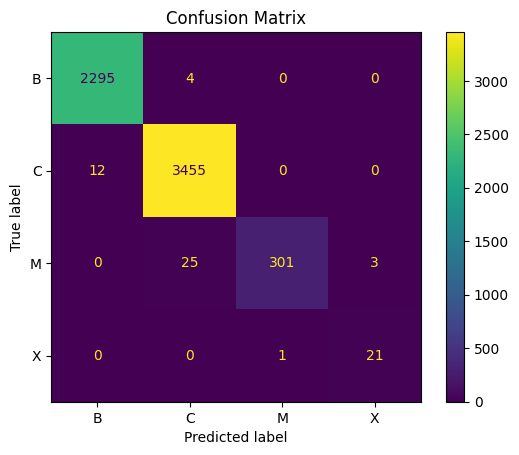

In [276]:
disp = ConfusionMatrixDisplay.from_estimator(classifier, testX, testY, display_labels=classNames)
disp.ax_.set_title("Confusion Matrix")

## Plot Predictions vs. Actual Results

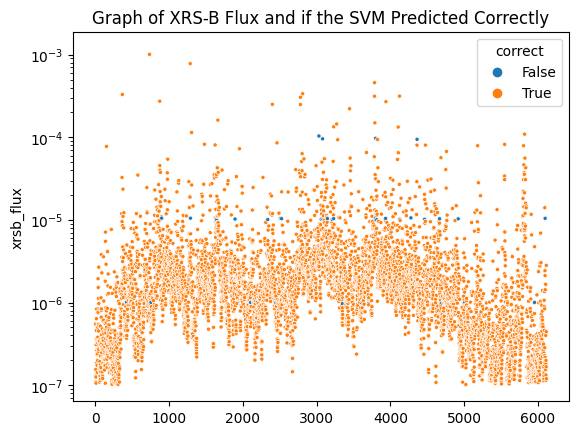

In [277]:
test['correct'] = test['flare_type'] == test['prediction']
sns.scatterplot(data=test, x=[i for i in range(len(test))], y="xrsb_flux", hue='correct', marker='.')
plt.yscale("log")
plt.title("Graph of XRS-B Flux and if the SVM Predicted Correctly")
plt.show()

In [278]:
# Number of false predictions
display(len(test[test.correct == False]))

45

In [279]:
def MonteCarloCrossValidation(n, split, data, features, classes, classNames):
    clf = svm.SVC(kernel='rbf', class_weight={"B": 200, "C": 200, "M": 5, "X": 100})
    metrics = {}
    for cls in classNames:
        metrics[cls] = {"p": 0, "r": 0, "f": 0, "s": 0}
    for _ in range(n):
        trainCount = int(split * len(data))
        trainIndices = np.random.choice(data.index,trainCount,replace=False)
        train = data[data.index.isin(trainIndices)]
        test = data[data.index.isin(trainIndices) == False]
        trainX = train[features]
        trainY = train[classes]
        testX = test[features]
        testY = test[classes]

        clf.fit(trainX,trainY.values.reshape(len(trainY),))
        predY = clf.predict(testX)
        p, r, f, s = precision_recall_fscore_support(testY, predY)
        for i in range(len(classNames)):
            metrics[classNames[i]]["p"] += p[i]
            metrics[classNames[i]]["r"] += r[i]
            metrics[classNames[i]]["f"] += f[i]
            metrics[classNames[i]]["s"] += s[i]
    for val in metrics.values():
        for key in val.keys():
            val[key] /= n
    return metrics

display("Average p,r,f,s for each class:")
MonteCarloCrossValidation(10,0.7,xrayData,features,classes,classNames)

'Average p,r,f,s for each class:'

{'B': {'p': 0.9950391973113412,
  'r': 0.9973673747202308,
  'f': 0.9962006672655596,
  's': 2352.7},
 'C': {'p': 0.9899641380187021,
  'r': 0.9965689322013143,
  'f': 0.993254600943333,
  's': 3405.7},
 'M': {'p': 0.9980344865113775,
  'r': 0.911275402128686,
  'f': 0.9526566500413385,
  's': 335.7},
 'X': {'p': 0.9370618850595968,
  'r': 0.9764472170765076,
  'f': 0.9556037362281218,
  's': 22.9}}

## Now, try predicting based on only one feature

We use Monte Carlo Cross Validation to see how our model does with only one feature

In [280]:
display("Based on Standardized Flux")
display(MonteCarloCrossValidation(4,0.7,xrayData,["flux_standardized"], classes, classNames))
display("Based on Standardized Background Flux")
display(MonteCarloCrossValidation(4,0.7,xrayData,["background_standardized"], classes, classNames))
display("Based on Standardized Integrated Flux")
MonteCarloCrossValidation(4,0.7,xrayData,["integrated_standardized"], classes, classNames)

'Based on Standardized Flux'

{'B': {'p': 0.9987302585797928,
  'r': 0.9996819338422391,
  'f': 0.9992052974376275,
  's': 2360.5},
 'C': {'p': 0.9934964365375754,
  'r': 0.999121308106479,
  'f': 0.9962996228639809,
  's': 3402.0},
 'M': {'p': 1.0,
  'r': 0.9343346837106077,
  'f': 0.9659968456494201,
  's': 334.25},
 'X': {'p': 0.9803030303030303, 'r': 1.0, 'f': 0.9899487583760347, 's': 20.25}}

'Based on Standardized Background Flux'

c:\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'B': {'p': 0.8223935493695269,
  'r': 0.9221719507637023,
  'f': 0.8693969881496102,
  's': 2336.25},
 'C': {'p': 0.8580955715516667,
  'r': 0.8681853832911387,
  'f': 0.8630904874090802,
  's': 3432.75},
 'M': {'p': 0.9495192307692308,
  'r': 0.050160805837312084,
  'f': 0.09437467307709069,
  's': 328.0},
 'X': {'p': 0.025, 'r': 0.0125, 'f': 0.016666666666666666, 's': 20.0}}

'Based on Standardized Integrated Flux'

{'B': {'p': 0.903189053718931,
  'r': 0.9076946083533484,
  'f': 0.9053914291127734,
  's': 2339.75},
 'C': {'p': 0.8644392523587757,
  'r': 0.9330826555894788,
  'f': 0.8973724884611364,
  's': 3413.25},
 'M': {'p': 0.9459678405478111,
  'r': 0.07077251801597137,
  'f': 0.12807554474393584,
  's': 343.25},
 'X': {'p': 0.3490161484914108,
  'r': 0.939408950182944,
  'f': 0.5080057266676985,
  's': 20.75}}

**Result:**  Model seems to perform *better* with only the standardized XRS-B flux. Let's compare that model with the full model, and with a model excluding the background flux, which seems to perform the worst.

In [281]:
display(MonteCarloCrossValidation(10,0.7,xrayData,['flux_standardized'],classes, classNames))
display(MonteCarloCrossValidation(10,0.7,xrayData,['flux_standardized','integrated_standardized'],classes, classNames))
MonteCarloCrossValidation(10,0.7,xrayData,features,classes, classNames)

{'B': {'p': 0.998450544905773,
  'r': 0.9997407988936864,
  'f': 0.9990939631325457,
  's': 2324.5},
 'C': {'p': 0.9933370068662516,
  'r': 0.9989551794389092,
  'f': 0.9961375307657567,
  's': 3429.3},
 'M': {'p': 0.9996923076923077,
  'r': 0.9331670307832475,
  'f': 0.965241209266309,
  's': 340.4},
 'X': {'p': 0.9874545454545455,
  'r': 0.9962962962962962,
  'f': 0.9917059934987599,
  's': 22.8}}

{'B': {'p': 0.996423157437072,
  'r': 0.9986774835370037,
  'f': 0.997548620908652,
  's': 2334.6},
 'C': {'p': 0.9920678333230943,
  'r': 0.9975415084673079,
  'f': 0.9947964328226986,
  's': 3424.4},
 'M': {'p': 0.9984463227868137,
  'r': 0.9256286164054485,
  'f': 0.9606216914858772,
  's': 337.3},
 'X': {'p': 0.9561764713166315,
  'r': 0.9763544891640867,
  'f': 0.9655164274249997,
  's': 20.7}}

{'B': {'p': 0.994370072230689,
  'r': 0.9970133973256283,
  'f': 0.9956890941048103,
  's': 2339.1},
 'C': {'p': 0.9897672726670546,
  'r': 0.9961517909574944,
  'f': 0.9929485245911958,
  's': 3427.3},
 'M': {'p': 0.9962309115515222,
  'r': 0.9097162669160829,
  'f': 0.9509594346104189,
  's': 329.4},
 'X': {'p': 0.9336912693205599,
  'r': 0.9452836141737743,
  'f': 0.9380285245522927,
  's': 21.2}}

The model performs best when only the standardized XRS-B flux is used, so we will simplify our model:

{'precision': array([0.99826314, 0.99368723, 1.        , 1.        ]),
 'recall': array([1.        , 0.99884626, 0.9331307 , 1.        ]),
 'f-score': array([0.99913081, 0.99626007, 0.96540881, 1.        ]),
 'support': array([2299, 3467,  329,   22], dtype=int64)}

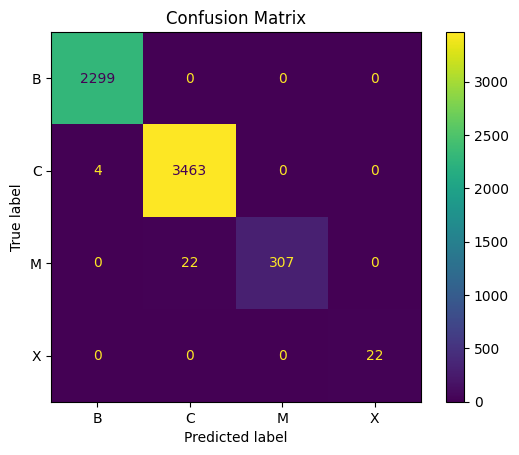

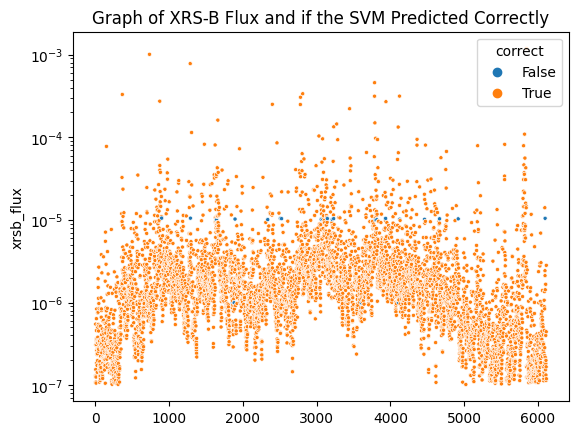

26

In [282]:
# -- DEFINE INPUT AND OUTPUT --
features = ['flux_standardized']
# features = ['xrsb_flux', 'background_flux', 'integrated_flux']
X = xrayData[features]
trainX = train[features]
testX = test[features]

# classNames = ["A","B", "C", "M", "X"]
classNames = ["B", "C", "M", "X"]
classes = ['flare_type']
y = xrayData[classes]
trainY = train[classes]
testY = test[classes]

# -- DEFINE MODEL --
classifier = svm.SVC(kernel='rbf', class_weight={"B": 200, "C": 200, "M": 5, "X": 100})
classifier.fit(trainX,trainY.values.reshape(len(trainY),))

# -- PREDICT --
y_pred = classifier.predict(testX)
test = test.assign(prediction=y_pred)
metrics = {"precision": 0, "recall": 0, "f-score": 0, "support": 0}
p, r, f, s = precision_recall_fscore_support(testY, y_pred, labels=classNames)
metrics['precision'] = p
metrics["recall"] = r
metrics['f-score'] = f
metrics['support'] = s
display(metrics)

# -- MAKE PLOTS --
disp = ConfusionMatrixDisplay.from_estimator(classifier, testX, testY, display_labels=classNames)
disp.ax_.set_title("Confusion Matrix")
plt.show()

test['correct'] = test['flare_type'] == test['prediction']
sns.scatterplot(data=test, x=[i for i in range(len(test))], y="xrsb_flux", hue='correct', marker='.')
plt.yscale("log")
plt.title("Graph of XRS-B Flux and if the SVM Predicted Correctly")
plt.show()

# Number of false predictions
display(len(test[test.correct == False]))